# Personality clustering

Topic: Using Logic Tensor Networks in order to identify and create clusters that represent different types of personalities.



### Why Logic Tensor Networs?

Logic Tensor Networks is a framework that supports querying, learning and reasoning. Just by defining some logical constraints, we can let the neural network learn without the need to pass in the labels.
There are many interesting ways of defining those types of constraints, which we will analyse in a bit.

### Dataset

The dataset we will be using is the following: https://www.kaggle.com/datasets/anshulmehtakaggl/60k-responses-of-16-personalities-test-mbt. Unfortunately, it is a synthetic generated dataset, so the results might differ from real world.
This database contains answers for 60 personality questions, along with the results. For simplicity, we will train our LTN on 2000 entries of 3 different personalities: ISTJ (Logistician), ESFP (Entertainer), ENTP (Debater). This is in order to make sure the distances between the personalities can be correctly displayed in a 2-dimesional space.

### Approach

Each answer in the dataset has 5 possible values:
* -3: Fully disagree
* -2: Partially disagree
* -1: Slightly disagree
*  0: Neutral
*  1: Slightly agree
*  2: Partially agree
*  3: Fully agree

We start from the premise that people with similar personalities will answer each question in a similar fashion. The more different the answers, the higher the probability that they have different personalities. We will introduce the concept of "penalty": the more different the answer, the higher the penalty should be. A good way of defining the penalty on a question is by taking the answer difference to the power of 2.

Example:
Question: "You regularly make new friends"  
Jack's answer: 2 (partially agree)  
Tom's answer: 0 (neutral)  
Emily's answer: -1 (slightly disagree)  

We can conclude that Tom and Emily are quite similar (penalty of 1), that Tom and Jack are not completely different (penalty of 2^2 = 4), but Emily and Jack are quite far away (penalty of 3^2 = 9).

The good part about this penalty system is that it allows us to use the euclidean distance between the arrays of answers as a starting point when clustering: the smaller the distance, the higher the chance to be in the same cluster.


## Coding

This code was built similar to the examples and tutorials from the official Logic Tensor Network pages: 
* https://github.com/logictensornetworks/logictensornetworks 
* https://github.com/logictensornetworks/LTNtorch  
Some of the examples were a bit outdated, but they let us see different approaches to clustering and managing data.


In [103]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ltn
import pandas as pd
import csv
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import keras

### Data fetching
We will parse the '16P.csv' file that can be downloaded from this link: https://www.kaggle.com/datasets/anshulmehtakaggl/60k-responses-of-16-personalities-test-mbt.  
As said earlier, we will work initially only on 2000 entries, with 3 types of personalities.
We will also split the data into batches, cut off the entry id and cut off the labels. We will however keep those labels in a list, so we can later test the accuracy of the training.

In [104]:

csv_file_path = '16P.csv'

data = []

with open(csv_file_path, 'r', encoding='ISO-8859-1', newline='') as csvfile:
    csv_reader = csv.reader(csvfile)

    header = next(csv_reader, None)
    
    current_line = 1
    data = [row for row in csv_reader]


data_to_train_on = []
labels = []
for row in data:
    row_to_float = []
    if row[-1] in ['ISTJ', 'ESFP', 'ENTP']:
        for i in range(1, len(row)-1):
            row_to_float.append(float(row[i]))
        labels.append(row[-1])
        data_to_train_on.append(row_to_float)
    
data_to_test_on = data_to_train_on[2000:3000]
data_to_train_on = data_to_train_on[:1000]

test_labels = labels[2000:3000]
labels = labels[:1000]

data_to_train_on = np.array(data_to_train_on)
data_to_test_on = np.array(data_to_test_on) 

    
batch_size = 150    
current_batch = []
batches = []
 
for rownum in range(len(data_to_train_on)):
    if rownum % batch_size == 0 and rownum > 0:
        batches.append(current_batch)
        current_batch = []
    current_batch.append(data_to_train_on[rownum])
 
if len(current_batch):
    batches.append(current_batch)
    
 

### KMeans Clustering

In [96]:
kmeans_model = KMeans(n_clusters=3, random_state=42)
kmeans_model.fit(data_to_train_on)
kmeans_labels = kmeans_model.labels_

predicted_labels = kmeans_model.predict(data_to_test_on)

C:\Users\Maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


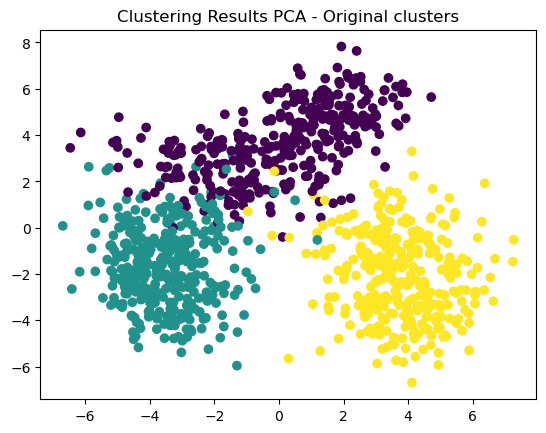

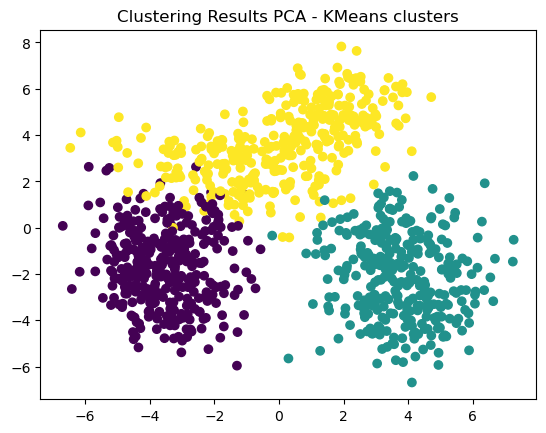

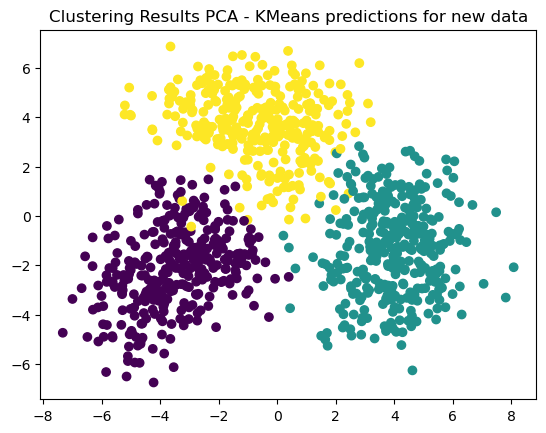

In [97]:
# Plots #

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_to_train_on)
l = ['ISTJ', 'ESFP', 'ENTP']
numeric_labels = []
for elem in labels:
    numeric_labels.append(l.index(elem) + 1)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=numeric_labels, cmap='viridis')
plt.title('Clustering Results PCA - Original clusters')
plt.show()


plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('Clustering Results PCA - KMeans clusters')
plt.show()


pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_to_test_on)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=predicted_labels, cmap='viridis')
plt.title('Clustering Results PCA - KMeans predictions for new data')
plt.show()

### Neuro-symbolic Clustering

We build the classifier for our network. We are defining the sizes of the hidden layers, the activation function (we chose elu in this case).
We can use the softmax function so that the output nodes have a total probability of 1. If there one can have more personalities (not the case here), we can use sigmoid instead.
We specify the number of clusters: same as the number of personalities, 3.

In [105]:
from tensorflow.keras import layers
 
@keras.saving.register_keras_serializable()

class MLP_classifier(tf.keras.Model):
    """ Model to call as P(x,class) """
    def __init__(self, n_classes, single_label, hidden_layer_sizes=(32, 32, 32)):
        super(MLP_classifier, self).__init__()
        self.denses = [layers.Dense(s, activation="elu") for s in hidden_layer_sizes]
        self.dense_class = layers.Dense(n_classes)
        self.to_probs = tf.nn.softmax if single_label else tf.math.sigmoid
 
    def call(self, inputs):
        x, c = inputs[0], inputs[1]
        for dense in self.denses:
            x = dense(x)
        logits = self.dense_class(x)
        probs = self.to_probs(logits)
        indices = tf.cast(c, tf.int32)
        return tf.gather(probs, indices, batch_dims=1) 

my_model = MLP_classifier(3, single_label=True)
C = ltn.Predicate(my_model)


Declaring a list of clusters. Notice the use of <code>ltn.Variable</code> to ground this.

In [106]:
clst_ids = range(3)

cluster = ltn.Variable("cluster", clst_ids)

### Defining logic functions
As mentioned earlier, LTN introduces the term <i>grounding</i>: defining abstract human concepts using functions and tensors. Since we are working with probabilities, there are many ways to define the logical operators. This happens because each logical operator acts like a function that takes two parameters, and there is no set way of computing that result. However, this is not a bad thing: we can play around, define them more loosely or more strictly.  
We will use the recommended ones (from the official documentation), but if needed, we might change them later.  
We will also define an aggregator which we will use in order to compute the satisfiability value of our constraints.

In [107]:

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Equiv = ltn.Wrapper_Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.And_Prod(),ltn.fuzzy_ops.Implies_Reichenbach()))
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=4),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=6),semantics="exists")

formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))


### Defining axioms
The beauty of Logic Tensor Networks is that we can define rules and constraints in a human readable way.  
Some rules of clustering would be:
* every element should be assigned to a cluster
* every cluster should contain at least one element
In addition to these 2 obvious rules, we need to define how to handle the relationships between the elements and clusters.  
We have more ways to do so, and we will discuss each of them now.

#### Approach #1:

We use the euclidean distance to measure the similarity between two sets of answers. In order to transform it into a probability that can be used, we can define a Predicate:

In [108]:
Sim = ltn.Predicate.Lambda(
    lambda args: tf.exp(-1.*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))
)

Next, we define the following rules (axioms):
* x and y are two variables from the current batch
* for each variable x, there exists a cluster that contains x
* for each cluster, there exists a variable x that is a part of the cluster
* for all variables x and y, the amount of similarity between x and y determines (implies) if the x and y are in the same cluster (x in cluster <=> y in cluster)  

In the end, we need to return how much these conditions hold.

Translating these rules into code:

In [109]:
def axioms(p_exists, batch):
 
    x = ltn.Variable("x", batch)
    y = ltn.Variable("y", batch)    
 
    axioms = [
        Forall(x, Exists(cluster, C([x,cluster]),p=p_exists)),
        Forall(cluster, Exists(x, C([x,cluster]),p=p_exists)),
        Forall(
            [x, y, cluster],
            Implies( Sim([x, y]),
                    Equiv(C([x, cluster]),C([y, cluster]))
                    )
        )
    ]
    kb = formula_aggregator(axioms)
    sat = kb.tensor
    return sat


#### Approach #2: 

We will still use the euclidean distance. However, this time we don't transform it into a predicate. We will use however two more threshold distances that will help the network decide if two elements need to be in the same cluster or different clusters.  
We can also declare a predicate that turns the difference between two distances into a probability. 

In [89]:
eucl_dist = ltn.Function.Lambda(lambda inputs: tf.expand_dims(tf.norm(inputs[0]-inputs[1],axis=1),axis=1))
is_greater_than = ltn.Predicate.Lambda(lambda inputs: inputs[0] > inputs[1])

We want to define two limits for the distance between two elements:
* the first limit indicates that any two elements that have the distance under the threshold need to be in the same clusters
* the second limits indicates that any two elements that have the distance above the threshold need to be in different clusters  

How do we choose the limits?  
Actually, it's kind of experimental, because we don't know from the start those values.  
A good starting point would be to think how much the answers differ for two people that have the same personality.
We can say, since we only have 4 quite distinct personalities, that if the difference between answers is on average a maximum of 2, they probably belong in the same cluster.  
We have a penalty of 2^2 per question in this case, and 60 questions per entry, so a penalty of 240. Since we use the euclidean distance, sqrt(240) = 15.491  
Similarly, a difference of 4 would be way too much, so we can set the threshold to be sqrt(4^2 * 60) ≈ 31.

However, while this approach might get us a high satisfiability ratio, it might not clusterize the elements corrently. This is happening because there are small "gaps" between each cluster, and those small gaps might be overshadowed if the close or distant threshold are to big. We need a way to make sure that gap stays relevant, so we will choose much smaller thresholds:

In [90]:
close_threshold = 8
distant_threshold = 20

close_thr = ltn.Constant(close_threshold, trainable=False)
distant_thr = ltn.Constant(distant_threshold, trainable=False)

Next, we define the following rules (axioms):
* x and y are two variables from the current batch
* for each variable x, there exists a cluster that contains x
* for each cluster, there exists a variable x that is a part of the cluster
* for each x, y and cluster, if the points are close to each other, they should belong to the same cluster
* for each x, y and cluster, if the points are far from each other, they should belong to different clusters

In the end, we need to return how much these conditions hold.

Translating these rules into code:

In [42]:
def axioms(p_exists, batch):
    x = ltn.Variable("x", batch)
    y = ltn.Variable("y", batch)    

    axioms = [
        Forall(x, Exists(cluster, C([x,cluster]),p=p_exists)),
        Forall(cluster, Exists(x, C([x,cluster]),p=p_exists)),
        Forall([cluster,x,y], And(C([x,cluster]),C([y,cluster])),
            mask = is_greater_than([close_thr, eucl_dist([x,y])])),
        Forall([cluster,x,y], Not(And(C([x,cluster]),C([y,cluster]))),
            mask = is_greater_than([eucl_dist([x,y]), distant_thr]))
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

### Approach #3:

This approach relies on us giving the network some examples of initial nodes that belong to each individual cluster. We can give him an example of an answer that is labeled as 'ISTJ', another that is labeled as 'ESPF', and another one that is labeled as 'ENTP'. This approach will ensure that the predicted clusters will have the same label as the original ones. However, if one of the examples is a special case / a more in-between personality, this might fail, since the distance to another personality might be smaller than ones of its own.  
Just for illustrating this approach quickly, we won't handpick those examples, but we will take the first matching entries we find in the dataset. 

In [87]:

# Given keys
given_keys = ['ISTJ', 'ESFP', 'ENTP']

# Create a dictionary with given keys and empty values
my_labels = {key: None for key in given_keys}

labels_found = 0 
#print(data_to_train_on[:1])
for elem_idx in range(len(data_to_train_on)):
    if labels_found == 3:
        break

    if my_labels[labels[elem_idx]] is None:
        my_labels[labels[elem_idx]] = data_to_train_on[elem_idx]
        labels_found += 1

#print(my_labels)

We will feed the network an example of each different label.

In [88]:
istj = ltn.Constant(my_labels['ISTJ'], trainable = False)
esfp = ltn.Constant(my_labels['ESFP'], trainable = False)
entp = ltn.Constant(my_labels['ENTP'], trainable = False)
istj_label = ltn.Constant(0, trainable = False)
esfp_label = ltn.Constant(1, trainable = False)
entp_label = ltn.Constant(2, trainable = False)

Next, we can declare the necessary axioms:  
* the example entry istj should be in the cluster ISTJ
* the example entry esfp should be in the cluster ESFP
* the example entry entp should be in the cluster ENTP
* as in the 1st approach, each element should be in a cluster, and the similarity between personalities should determine the similarity between their assigned clusters.

In [13]:
def axioms(p_exists, batch):
 
    x = ltn.Variable("x", batch)
    y = ltn.Variable("y", batch)    
 
    axioms = [
        C([istj, istj_label]),
        C([esfp, esfp_label]),
        C([entp, entp_label]),
        Forall(x, Exists(cluster, C([x,cluster]),p=p_exists)),
        Forall(
            [x, y, cluster],
            Implies( Sim([x, y]),
                    Equiv(C([x, cluster]),C([y, cluster]))
                    )
        )
    ]
    kb = formula_aggregator(axioms)
    sat = kb.tensor
    return sat

### Training

First, we need to initialize the process, we'll just use the first batch:

In [110]:
first_batch = batches[0]
axioms(6, first_batch)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5575107>

Next, we define a function that helps us output the average sat throughout the batches, mostly for outputing the progress:

In [111]:
def calculate_avg_sat():
    avg = 0.
    for batch in batches:
        avg += axioms(p_exists, batch)
    avg = avg / len(batches)
    return avg

Now we need to define the learning rate, and start the training process.  
We played around a bit with the learning rate, and anything more than 0.01 is too high, and under 0.001 is a bit low. For our case, 0.001 looks like to be the sweet spot.  

For each step, we need to set the p_exists (parameter for how loose the axioms are), iterate through all the batches, then ajust the weights based on the loss function: 1. - axioms(p_exists, batch)  
After each 100 steps, we will display the current status, using the function from above:

In [112]:

def cluster_plotting():
    
    predictions = []
    for input in data_to_train_on:
        current_prediction_tensors = [C.model([tf.constant([input]), tf.constant([[i]])]) for i in clst_ids]
        current_prediction = [tensor.numpy()[0][0] for tensor in current_prediction_tensors]
        predictions.append(current_prediction)

    predicted_labels = []
    for prediction in predictions:
        predicted_cluster = np.array(prediction).argmax() + 1
        predicted_labels.append(predicted_cluster)

        pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data_to_train_on)

    l = ['ISTJ', 'ESFP', 'ENTP']
    numeric_labels = []
    for elem in labels:
        numeric_labels.append(l.index(elem) + 1)

    #plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=numeric_labels, cmap='viridis')
    #plt.title('Clustering Results PCA - Original clusters')
    #plt.show()


    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data_to_train_on)

    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=predicted_labels, cmap='viridis')
    plt.title('Clustering Results PCA - Predicted clusters')
    plt.show()


Epoch 0: Sat Level 0.452


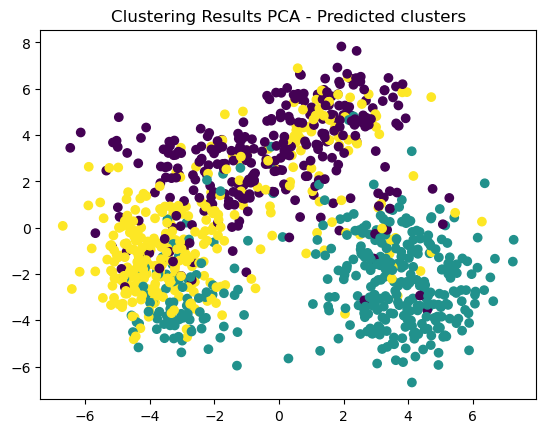

Epoch 100: Sat Level 0.456


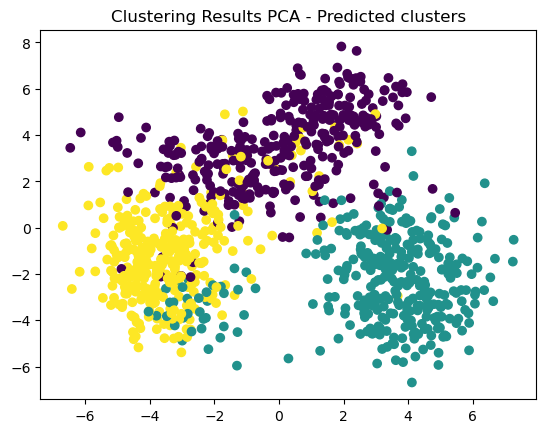

Epoch 200: Sat Level 0.863


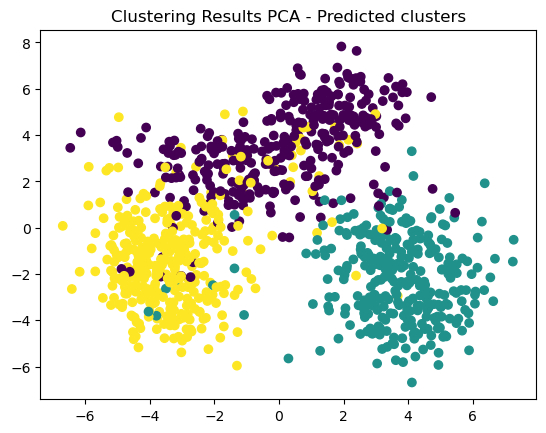

Epoch 300: Sat Level 0.863


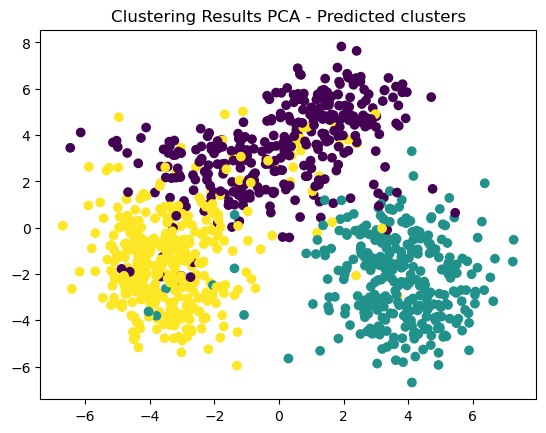

Training finished at Epoch 399 with Sat Level 0.863


In [113]:

trainable_variables = C.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
 

for epoch in range(400):
    if epoch <= 100:
        p_exists = 1
    else:
        p_exists = 6
    for batch in batches:
        with tf.GradientTape() as tape:
            loss_value = 1. - axioms(p_exists, batch)
        grads = tape.gradient(loss_value, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
 
    if epoch%100 == 0:
        print("Epoch %d: Sat Level %.3f"%(epoch, calculate_avg_sat()))
        cluster_plotting()
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, calculate_avg_sat()))
 

### Getting the results

Usually, you would need to have separate training data and test data. However, since we provided no labels, we can use the same training data in order to check the clusterization results.
We test each input individually, retreiving the output data from the network. The value of each output node indicates the likelyhood that the input is assigned to the coresponding cluster. Obviously, we will consider the node that has the highest probability as the result.

In [121]:
predictions = []
for input in data_to_train_on:
    current_prediction_tensors = [C.model([tf.constant([input]), tf.constant([[i]])]) for i in clst_ids]
    current_prediction = [tensor.numpy()[0][0] for tensor in current_prediction_tensors]
    predictions.append(current_prediction)
 
predicted_labels = []
for prediction in predictions:
    predicted_cluster = np.array(prediction).argmax() + 1
    predicted_labels.append(predicted_cluster)


In [122]:
# predictions for new data

test_predictions = []
for input in data_to_test_on:
    current_prediction_tensors = [C.model([tf.constant([input]), tf.constant([[i]])]) for i in clst_ids]
    current_prediction = [tensor.numpy()[0][0] for tensor in current_prediction_tensors]
    test_predictions.append(current_prediction)
 
test_predicted_labels = []
for prediction in test_predictions:
    predicted_cluster = np.array(prediction).argmax() + 1
    test_predicted_labels.append(predicted_cluster)


### Checking the accuracy

We spent a bit of time deciding on how to define the accuracy, since the SAT value only indicates that clusters have been made, not if they are correctly coresponding to the actual labels.  
We decided that for each pair of people that are in the same predicted clusters, we will check if they have the same labels. Counting the number of the positive and the number of negative responses, we can get a percentage that would be our success rate, or the Accuracy.

In [123]:

misses = 0.
matches = 0.

data_size = len(data_to_train_on)
for index1 in range(data_size):
    for index2 in range(index1 + 1, data_size):
        if predicted_labels[index1] == predicted_labels[index2]:
            if labels[index1] == labels[index2]:
                matches += 1
            else:
                misses += 1

print("Matching clusters in proportion of ", matches / (matches + misses))
 

Matching clusters in proportion of  0.8659568217653795


In [124]:
# for new data

misses = 0.
matches = 0.

data_size = len(data_to_test_on)
for index1 in range(data_size):
    for index2 in range(index1 + 1, data_size):
        if test_predicted_labels[index1] == test_predicted_labels[index2]:
            if test_labels[index1] == test_labels[index2]:
                matches += 1
            else:
                misses += 1

print("Matching clusters in proportion of ", matches / (matches + misses))

Matching clusters in proportion of  0.9031830079485148


### More information

Accuracy does not tell everything. It also does not help us improve the network in any way. Therefore, we need a way to visualize the data, the clusters, and compare them to the original labels.  
We'll use a method that transforms arrays in a way that they can be plotted in a 2-dimensional environment.

C:\Users\moise\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


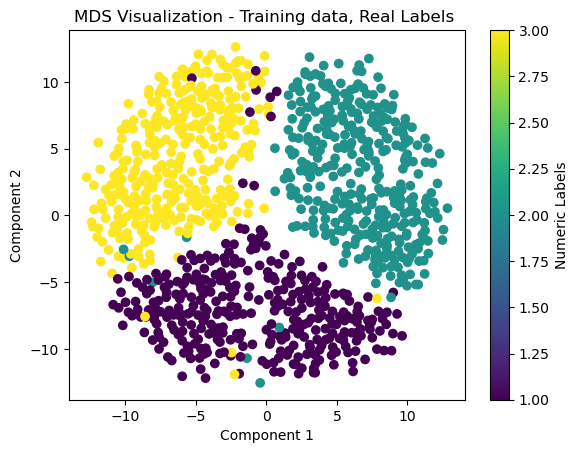

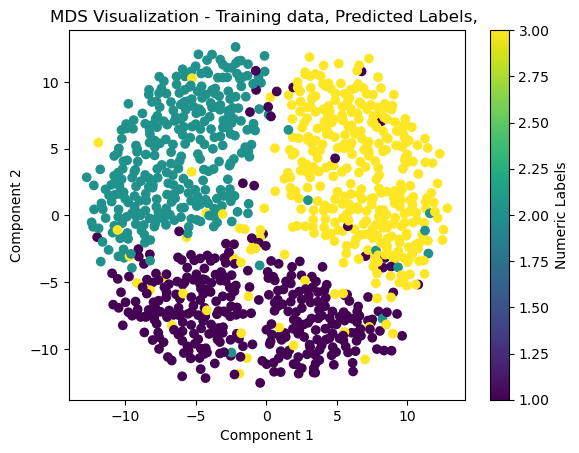

C:\Users\moise\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


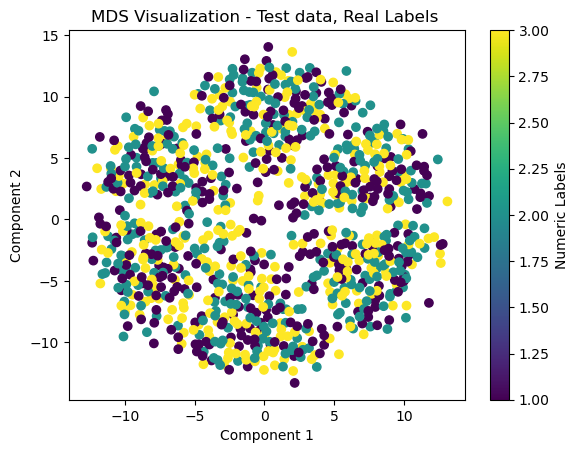

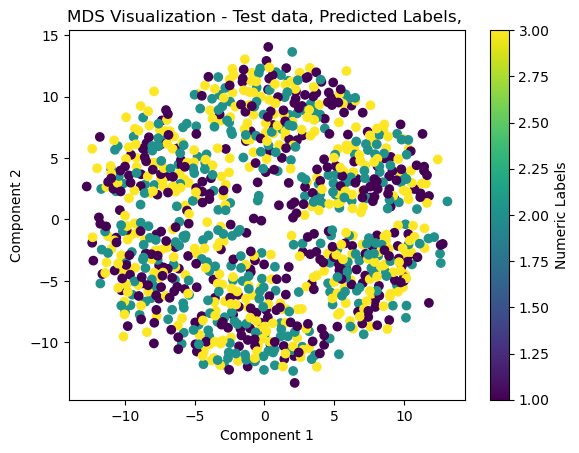

In [125]:
def plotting(input_data, title):
    l = ['ISTJ', 'ESFP', 'ENTP']
    numeric_labels = []
    for elem in labels:
        numeric_labels.append(l.index(elem) + 1)
    
    distances = np.linalg.norm(input_data[:, np.newaxis] - input_data, axis=2)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    embeddings = mds.fit_transform(distances)
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=numeric_labels, cmap='viridis', marker='o')
    plt.colorbar(label='Numeric Labels')
    plt.title('MDS Visualization - ' + title + ', Real Labels ')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=predicted_labels, cmap='viridis', marker='o')
    plt.colorbar(label='Numeric Labels')
    plt.title('MDS Visualization - ' + title + ', Predicted Labels, ')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()


plotting(data_to_train_on, "Training data")
plotting(data_to_test_on, "Test data")

### Saving the data
We need to be able to save the full network if the accuracy is good.
Fortunately, we can easily do this:

In [126]:
# Saving the model. Do not run unless you want to overwrite the previous model!
# If you want to save a new model, you need to create a new path.

my_model.save('model_app1.keras')

In [127]:
# Fetching the model

loaded_model = tf.keras.models.load_model('my_model.keras')
D = ltn.Predicate(loaded_model)

Now, you will be able to use the D model you just fetched just like the C one we used in this program:

In [32]:

predictions = []
for input in data_to_train_on:
    current_prediction_tensors = [D.model([tf.constant([input]), tf.constant([[i]])]) for i in clst_ids]
    current_prediction = [tensor.numpy()[0][0] for tensor in current_prediction_tensors]
    predictions.append(current_prediction)
 
predicted_labels = []
for prediction in predictions:
    predicted_cluster = np.array(prediction).argmax() + 1
    predicted_labels.append(predicted_cluster)

    
misses = 0.
matches = 0.

data_size = len(data_to_train_on)
for index1 in range(data_size):
    for index2 in range(index1 + 1, data_size):
        if predicted_labels[index1] == predicted_labels[index2]:
            if labels[index1] == labels[index2]:
                matches += 1
            else:
                misses += 1

print("Matching clusters in proportion of ", matches / (matches + misses))

Matching clusters in proportion of  0.9459159425855695


In [33]:
# for new data

loaded_predicate = tf.keras.models.load_model('model_app1.keras')
D = ltn.Predicate(loaded_predicate)

test_predictions = []
for input in data_to_test_on:
    current_prediction_tensors = [D.model([tf.constant([input]), tf.constant([[i]])]) for i in clst_ids]
    current_prediction = [tensor.numpy()[0][0] for tensor in current_prediction_tensors]
    test_predictions.append(current_prediction)
 
test_predicted_labels = []
for prediction in test_predictions:
    predicted_cluster = np.array(prediction).argmax() + 1
    test_predicted_labels.append(predicted_cluster)
    
misses = 0.
matches = 0.

data_size = len(data_to_test_on)
for index1 in range(data_size):
    for index2 in range(index1 + 1, data_size):
        if test_predicted_labels[index1] == test_predicted_labels[index2]:
            if test_labels[index1] == test_labels[index2]:
                matches += 1
            else:
                misses += 1

print("Matching clusters in proportion of ", matches / (matches + misses))

Matching clusters in proportion of  0.9671478646713283


## Conclusions